# Intro to MCMC in PyPWA with the 2D Gauss
    
In this tutorial we want to show how to use MCMC in PyPWA

**Note:**
Multiproccessing is done automatically when it's selected. However,
if you have some direct C/C++ code dependency in your Function on
called in your class's `__init__`, you will encounter issues. This
is why each object has a `setup` function- To initialize Fortran
and C++ dependencies there.

In [1]:
import numpy as np  # Vectorization and arrays
import pandas as pd  # A powerful data science toolkit
import numexpr as ne  # A threaded accelerator for numpy

import PyPWA as pwa
from IPython.display import display

There are 3 different supported ways to define your kernel/amplitude in
PyPWA.
- Using multiprocessing: Write your kernel using Numpy and include any
  externally compiled code the setup method. This is the default kernel,
  and will result in your kernel being deployed in parallel across all threads
  on the host system.
- Using Numexpr to use hardware threads and low level vectorization to
  further accelerate Numpy. There is some benefit to running Numexpr on less
  cores than traditional Numpy, but largely you can treat Numexpr the same as
  the above.
- Using Torch to compute the Kernel. This will allow you to take advantage of
  Metal on Apple PCs, or CUDA GPUs on Linux machines. However, to utilize CUDA,
  you must disable Multiprocessing. At this time, CUDA does not support the
  main process being forked.

In [2]:
class Gauss2dAmplitude(pwa.NestedFunction):
    """
    This is a simple 2D Gauss, but built to use PyPWA's builtin
    multiprocessing module. For you, you don't need to worry about thread or
    process management, how to pass data between threads, or any of the other
    hassles that come with multithreading.
    
    Instead, you just define your class while extending the NestedFunction,
    and when you pass it to the fitter or the simulator, it'll clone your
    class, split your data, and deploy to every processing thread your
    machine has.
    """

    def __init__(self):
        """
        You can override the init function if you need to set parameters
        before the amplitude is passed to the likelihood or simulation
        functions. You can see an example of this with the JPAC amplitude
        included in the other tutorials. However, you must remember
        to always call the `super` function if you do this.
        """
        super(Gauss2dAmplitude, self).__init__()

    def setup(self, array):
        """
        This function is where your data is passes too. Here you can also
        load any C or Fortran external libraries that typically would not
        support being packaged in Python's object pickles.
        """
        self.__x = array["x"]
        self.__y = array["y"]

    def calculate(self, params):
        """
        This function receives the parameters from the minimizer, and
        returns the values from there. Only the amplitude values should
        be calculated here. The likelihood will be calculated elsewhere.
        """
        scaling = 1 / (params["A2"] * params["A4"])
        left = ((self.__x - params["A1"])**2)/(params["A2"]**2)
        right = ((self.__y - params["A3"])**2)/(params["A4"]**2)
        return scaling * np.exp(-(left + right))

In [3]:
class NeGauss2dAmplitude(pwa.NestedFunction):
    """
    This is the same Gauss as above, but instead of using raw numpy, it
    uses numexpr, a hyper vectorized, multithreading, numerical package that
    should accelerate the calculation of your data.
    
    USE_MP defaults to True, but you should consider setting it to false.
    Numexpr will do some partial multithreading on its own for its
    calculations, however any part of your algorithm that is defined outside
    Numexpr will not benefit from Numexpr. Due to this, there is an optimum
    number of threads for amplitudes with Numexpr that range from 2 threads
    to around 80% of the system threads. A good starting point is around
    50% of the CPU threads available.
    """
    
    USE_MP = False 

    def setup(self, array):
        self.__data = array

    def calculate(self, params):
        return ne.evaluate(
            "(1/(a2*a4)) * exp(-((((x-a1)**2)/(a2**2))+(((y-a3)**2)/(a4**2))))",
            local_dict={
                "a1": params["A1"], "a2": params["A2"],
                "a3": params["A3"], "a4": params["A4"],
                "x": self.__data["x"], "y": self.__data["y"]
            }
        )

In [4]:
import torch as tc

class TorchGauss2dAmplitude(pwa.NestedFunction):
    """
    Finally, this is the Torch version of the Gauss2D.
    
    To utilize Torch, the USE_TORCH flag must be set to True, or the
    likelihood will assume that the results will be in standard Numpy
    arrays, and not Torch Tensors.

    Torch affords us some features that Numpy does not. Specifically,
    support for both Apple's Metal Acceleration, and CUDA Acceleration.
    For Apple's Metal, there is no work required further than defining
    your amplitude in Torch due to the shared memory on Apple systems.
    To utilize CUDA, however, you must move the data to the GPU before
    the GPU can accelerate the operations. Because of the nature of
    CUDA, CUDA and Multiprocessing are not compatible, so you must
    disable multiprocessing when using CUDA.

    **WARNING** You **MUST** set USE_MP to False if you are using
    CUDA as a Torch Device!
    """

    USE_TORCH = True
    USE_MP = False

    # device is not a flag for Amplitude, but we use it track the current
    # device that the amplitude should run on.
    device = ...  # type: tc.device

    def setup(self, array):
        # We want to always set the current device. It also helps to be able
        # to toggle GPU on and off for the entire amplitude using the USE_MP,
        # flag since the flag can be set after initialization.
        if self.USE_MP:
            self.device = tc.device("cpu")
        else:
            self.device = tc.device("cuda:0")

        # Since the data is in Pandas, we need to map it to Numpy first
        narray = pwa.pandas_to_numpy(array)

        self.__x = tc.from_numpy(narray["x"]).to(self.device)
        self.__y = tc.from_numpy(narray["y"]).to(self.device)

    def calculate(self, params):
        scaling = 1 / (params["A2"] * params["A4"])
        left = ((self.__x - params["A1"])**2)/(params["A2"]**2)
        right = ((self.__y - params["A3"])**2)/(params["A4"]**2)
        return scaling * tc.exp(-(left + right))

## Generate data
Check if it is already cached first

In [5]:
valid_cache, binned_flat = pwa.cache.read("flat_data")
if not valid_cache:
    flat_data = pd.DataFrame()
    flat_data["x"] = np.random.rand(10_000_000) * 20
    flat_data["y"] = np.random.rand(10_000_000) * 20
    flat_data["binning"] = np.random.rand(10_000_000) * 20
    binned_flat = pwa.bin_with_fixed_widths(flat_data, "binning", 1_000_000)
    pwa.cache.write("flat_data", binned_flat)

## Simulation with bins
Simulation can be run as a whole system, you simply provide the function
and data, and it'll return the masked values, or you can run the two steps
independently, with the first step returning the intensities, and the
second returning the masks. When your working with a single dataset, running
it as a single step make sense, however if you bin your data, then running
it as two steps is better so that all bins are masked against the same
max value of the intensity.

- `pwa.simulate.process_user_function` takes all the same arguments as
  `pwa.monte_carlo_simulation` so it can be a drop in replacement. The
   difference is that this function will return the final values for the
   user's function and the max value.
- `pwa.simulate.make_rejection_list` takes the final values and either a
   single max value, or a list or array of max values, and it'll use the
   largest max value. This function will return the same value as
  `pwa.monte_carlo_simulation`
  
Below, I iterate over the bins and produce the final values and max value
for each bin and store them in their own lists.

In [6]:
simulation_params = {
    "A1": 10, "A2": 3, 
    "A3": 10, "A4": 3
}

final_values = []
max_values = []
for fixed_bin in binned_flat:
    final, m = pwa.simulate.process_user_function(
        TorchGauss2dAmplitude(), fixed_bin, simulation_params
    )
    final_values.append(final)
    max_values.append(m)
    
pwa.cache.write("final_values", max_values)

After the final values have been produced, I use
`pwa.simulate.make_rejection_list` to reject events from each bin, and then
store the new carved results in a fresh list.

In [7]:
rejected_bins = []
masked_final_values = []
for final_value, bin_data in zip(final_values, binned_flat):
    rejection = pwa.simulate.make_rejection_list(final_value, max_values)
    rejected_bins.append(bin_data[rejection])
    masked_final_values.append(final_value[rejection])

pwa.cache.write("fitting_bins", rejected_bins, True)
pwa.cache.write("kept_final_values", masked_final_values, True)

In [8]:
for index, simulated_bin in enumerate(rejected_bins):
    print(
        f"Bin {index+1}'s length is {len(simulated_bin)}, "
        f"{(len(simulated_bin) / 1_000_000) * 100:.2f}% events were kept"
    )

Bin 1's length is 70474, 7.05% events were kept
Bin 2's length is 70612, 7.06% events were kept
Bin 3's length is 70866, 7.09% events were kept
Bin 4's length is 70533, 7.05% events were kept
Bin 5's length is 70888, 7.09% events were kept
Bin 6's length is 70957, 7.10% events were kept
Bin 7's length is 71084, 7.11% events were kept
Bin 8's length is 70362, 7.04% events were kept
Bin 9's length is 71067, 7.11% events were kept
Bin 10's length is 71151, 7.12% events were kept


## MCMC
Instead of using imuit like in the other 2Dgauss example this time we want to explore the parameterspace using Markov Chain Monte Carlo through the emcee package. When doing this it is important to set the is_minimizer flag to False in the LogLikelihood function, since emcee tries to maximize the likelihood.

In [9]:
fitting_settings = {
    "A1": 1.0, "A2": 1.0,
    "A3": 1.0, "A4": 1.0,
}

Then below, we can simply fit those values.

In [10]:
import emcee
import multiprocessing as mp
# Even though we're using Numexpr, I do want to take advantage of both
# multiprocessing and Numexpr's low level optimizations. So by selecting
# a small number of processes with Numexpr, you still get an overall
# speedup over either Numexpr or regular multiprocessing
NeGauss2dAmplitude.USE_MP = True

cpu_final_values= []
numwalker=10
numsteps=5000

for simulated_bin in rejected_bins:
    with pwa.LogLikelihood(
            NeGauss2dAmplitude(), simulated_bin,
            num_of_processes=int(mp.cpu_count() / 2), is_minimizer=False
    ) as likelihood:
        
        startpars = np.full((numwalker,len(fitting_settings)),list(fitting_settings.values()))
        parnames  = list(fitting_settings.keys())
        cov = 1
        optimizer = pwa.mcmc(parnames, likelihood,
                             nsteps     = numsteps,
                             startpars  = startpars,
                             parlimits  = [(0.1,20),(0.1,20),(0.1,20),(0.1,20)],
                             nwalker    = numwalker,
                             emceemoves=emcee.moves.GaussianMove(cov,'random')
                            )
        cpu_final_values.append(optimizer)
        break # just one bin

100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:45<00:00, 30.13it/s]


In [11]:
gpu_final_values = []
numwalker=10
numsteps=5000

for simulated_bin in rejected_bins:
    with pwa.LogLikelihood(TorchGauss2dAmplitude(), simulated_bin, is_minimizer=False) as likelihood:
        
        startpars = np.full((numwalker,len(fitting_settings)),list(fitting_settings.values()))
        parnames  = list(fitting_settings.keys())
        cov       = 0.3
        optimizer = pwa.mcmc(parnames, likelihood,
                             nsteps     = numsteps,
                             startpars  = startpars,
                             parlimits  = [(0.1,20),(0.1,20),(0.1,20),(0.1,20)],
                             nwalker    = numwalker,
                             emceemoves = emcee.moves.GaussianMove(cov,'random')
                            )

        gpu_final_values.append(optimizer)
        break # just one bin

100%|█████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:29<00:00, 169.53it/s]


## Draw chains and inspect results of MCMC
Do this for the cpu and gpu results and compare

Show results for bin #0


/tmp/ipykernel_200504/2796533490.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_200504/2796533490.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/tmp/ipykernel_200504/2796533490.py:51: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


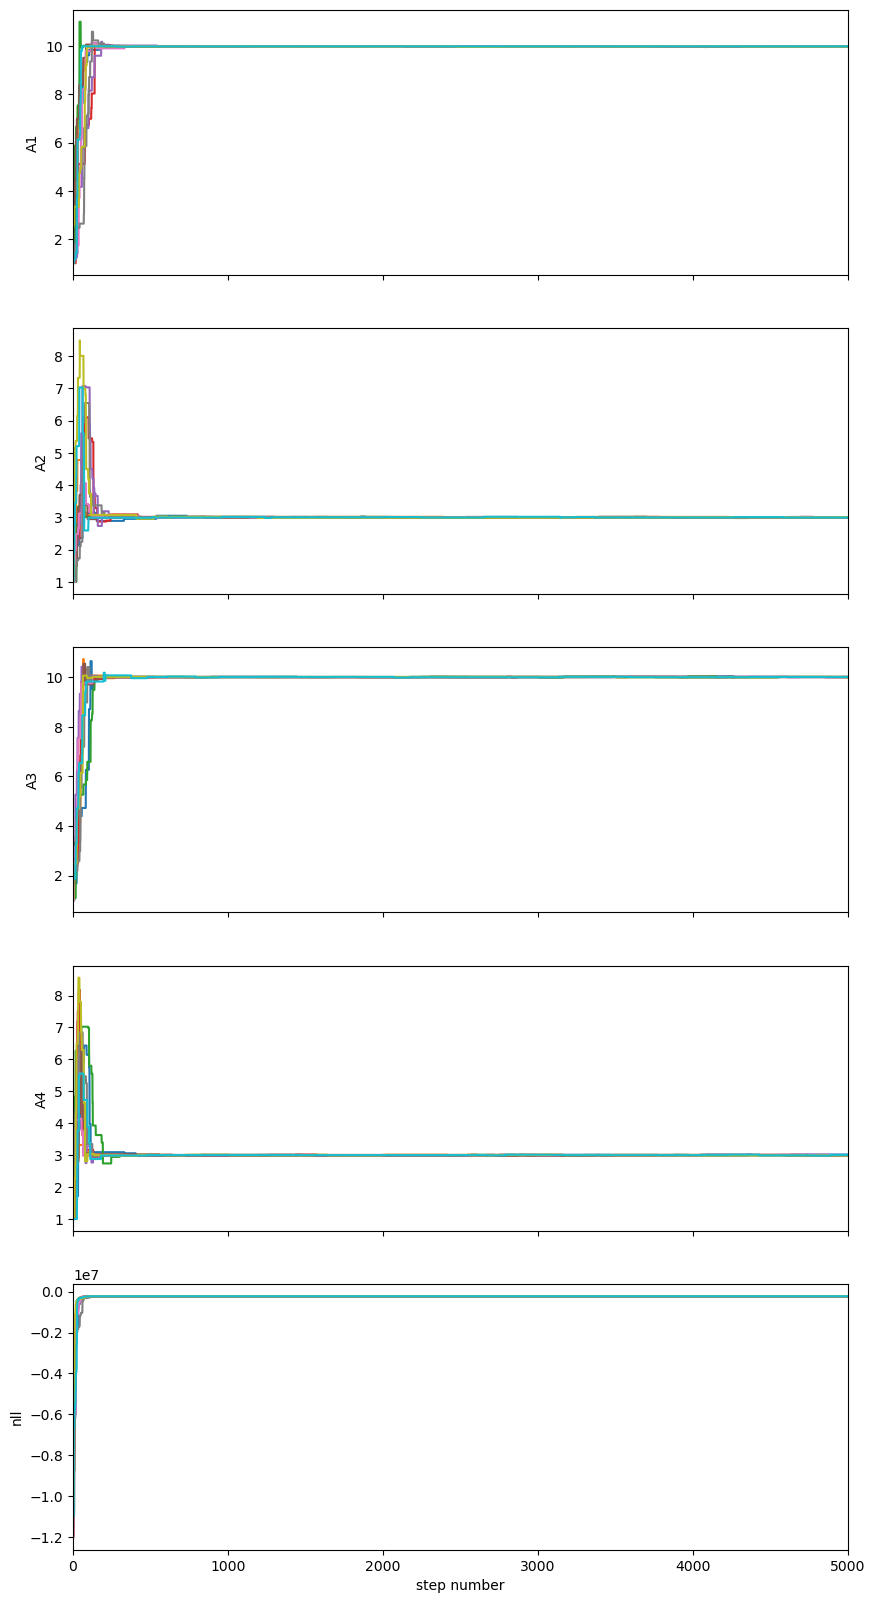

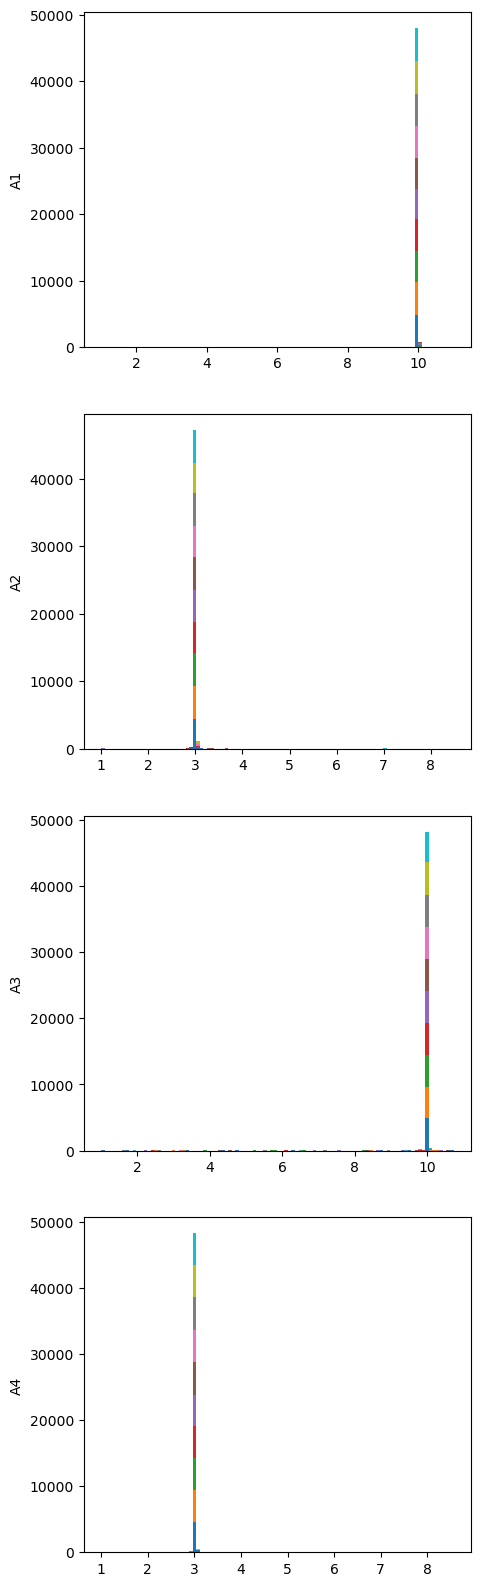

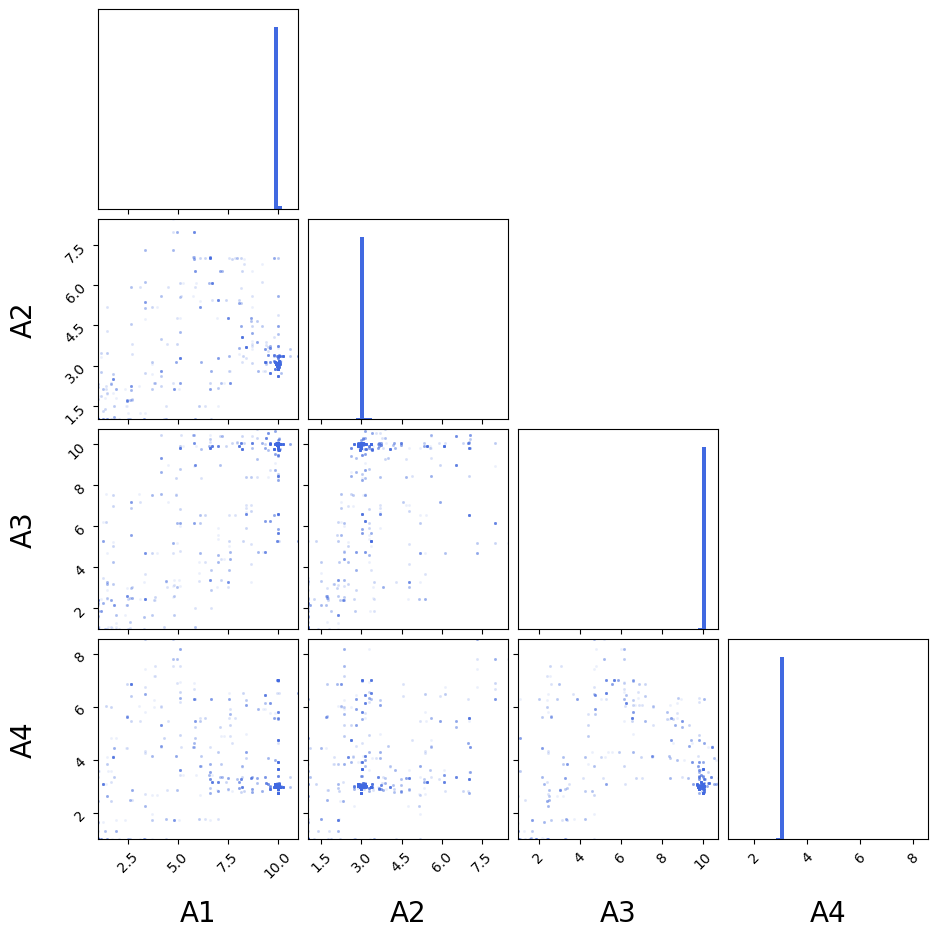

In [14]:
import matplotlib.pyplot as plt
import corner

burnin=0

for index, dbin in enumerate(rejected_bins):
    print(f"Show results for bin #{index}")
    
    parnames = list(fitting_settings.keys())
    
    samples = cpu_final_values[index].get_chain(discard=burnin)
    nlls    = cpu_final_values[index].get_log_prob(discard=burnin)
    
    numsteps = len(samples)
    numpars = samples.shape[2]
    fig, axes = plt.subplots(len(parnames)+1, figsize=(10, 20), sharex=True)
    for i in range(len(parnames)):
        ax = axes[i]
        ax.plot(samples[:,:,i])
        ax.set_ylabel(parnames[i])
        ax.set_xlim(0, numsteps)
    ax = axes[len(parnames)]
    ax.plot(nlls)
    ax.set_ylabel("nll")
    ax.set_xlim(0, numsteps)

    axes[-1].set_xlabel("step number");
    fig.show()
    
    samples = cpu_final_values[index].get_chain(discard=burnin)
    fig2, axes2 = plt.subplots(len(parnames), figsize=(5, 20), sharex=False)
    for i in range(len(parnames)):
        ax = axes2[i]
        ax.hist(samples[:,:,i], 100,histtype='barstacked')
        ax.set_ylabel(parnames[i])
    fig2.show()
    
    flatsample = cpu_final_values[index].get_chain(discard=burnin,flat=True)
    varrange = []
    for i in range(len(parnames)):
        varrange.append((flatsample[:,i].min(),flatsample[:,i].max()))
    fig3 = corner.corner(flatsample,
                        color='royalblue',
                        bins=50,
                        range=varrange,
                        labels=parnames,
                        fill_contours=True,
                        truth_color='red',
                        label_kwargs={'fontsize':20, 'labelpad':20},
                        hist_kwargs = {'histtype':'stepfilled','alpha':1})
    fig3.show()

    break #do this only for one bin

Show results for bin #0


/tmp/ipykernel_200504/1217592886.py:23: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
/tmp/ipykernel_200504/1217592886.py:31: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()
/tmp/ipykernel_200504/1217592886.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig3.show()


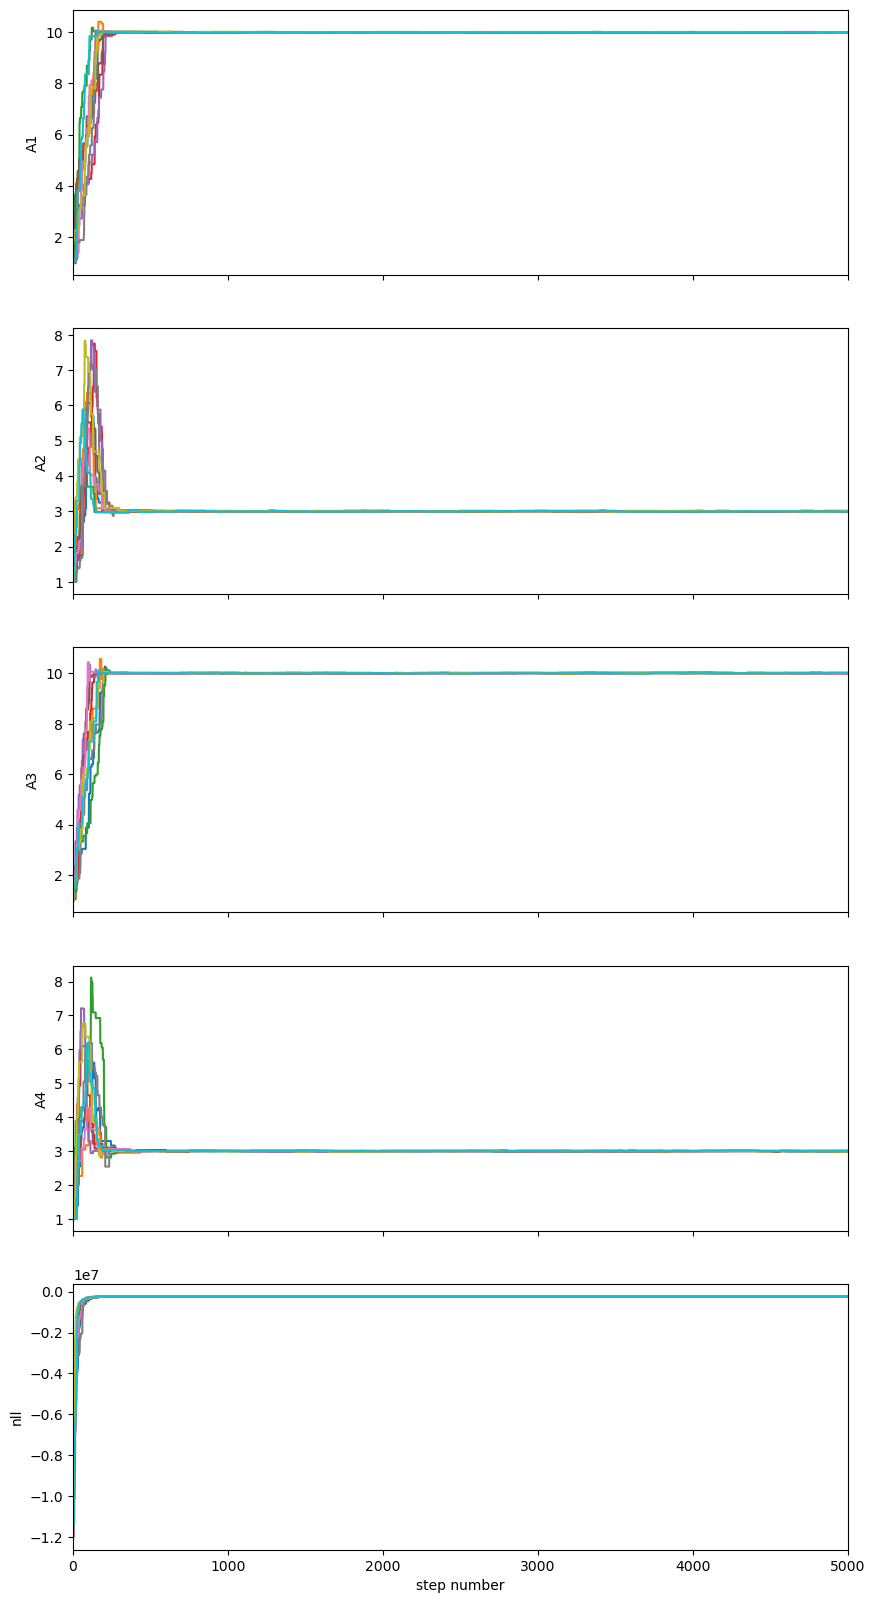

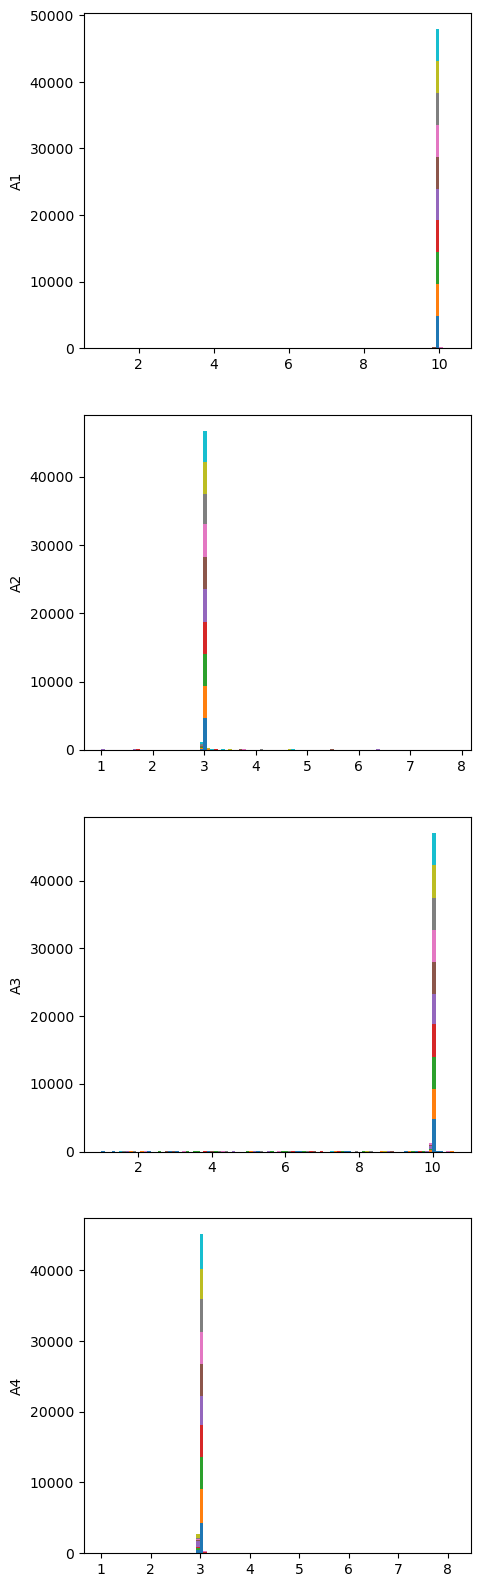

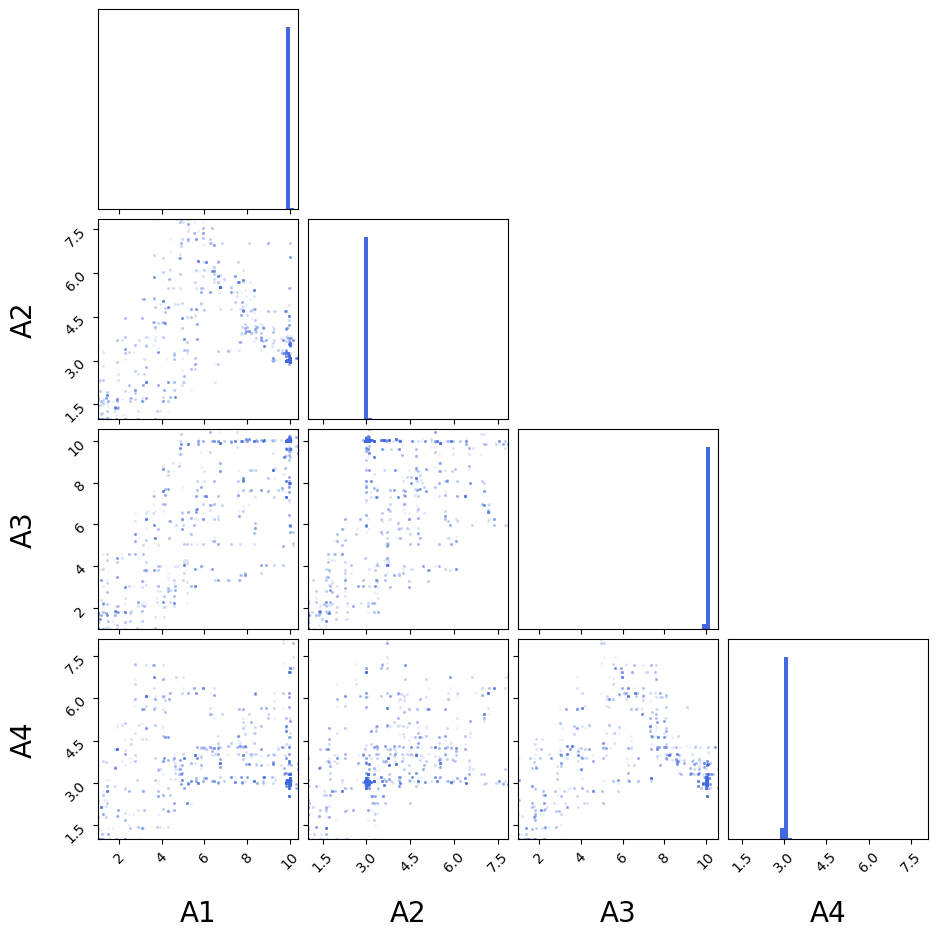

In [15]:
for index, dbin in enumerate(rejected_bins):
    print(f"Show results for bin #{index}")
    
    parnames = list(fitting_settings.keys())
    
    samples = gpu_final_values[index].get_chain(discard=burnin)
    nlls    = gpu_final_values[index].get_log_prob(discard=burnin)
    
    numsteps = len(samples)
    numpars = samples.shape[2]
    fig, axes = plt.subplots(len(parnames)+1, figsize=(10, 20), sharex=True)
    for i in range(len(parnames)):
        ax = axes[i]
        ax.plot(samples[:,:,i])
        ax.set_ylabel(parnames[i])
        ax.set_xlim(0, numsteps)
    ax = axes[len(parnames)]
    ax.plot(nlls)
    ax.set_ylabel("nll")
    ax.set_xlim(0, numsteps)

    axes[-1].set_xlabel("step number");
    fig.show()
    
    samples = gpu_final_values[index].get_chain(discard=burnin)
    fig2, axes2 = plt.subplots(len(parnames), figsize=(5, 20), sharex=False)
    for i in range(len(parnames)):
        ax = axes2[i]
        ax.hist(samples[:,:,i], 100,histtype='barstacked')
        ax.set_ylabel(parnames[i])
    fig2.show()
    
    flatsample = gpu_final_values[index].get_chain(discard=burnin,flat=True)
    varrange = []
    for i in range(len(parnames)):
        varrange.append((flatsample[:,i].min(),flatsample[:,i].max()))
    fig3 = corner.corner(flatsample,
                        color='royalblue',
                        bins=50,
                        range=varrange,
                        labels=parnames,
                        fill_contours=True,
                        truth_color='red',
                        label_kwargs={'fontsize':20, 'labelpad':20},
                        hist_kwargs = {'histtype':'stepfilled','alpha':1})
    fig3.show()

    break #do this only for one bin